In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from base import GeneDrugVAE
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import (adjusted_rand_score, completeness_score,
                             homogeneity_score, normalized_mutual_info_score,
                             silhouette_score)
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer
from utils import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
patients = pd.read_csv("../dataset/tcga/patients_info.csv.gz", index_col=0)
patients.head()

,project.project_id,cases.submitter_id,diagnoses.primary_diagnosis,treatments.therapeutic_agents,treatments.treatment_outcome,recist_label
0,TCGA-ACC,TCGA-OR-A5LL,Adrenal cortical carcinoma,Mitotane,'--,Unknown
1,TCGA-ACC,TCGA-OR-A5J7,Adrenal cortical carcinoma,Mitotane,Progressive Disease,0
2,TCGA-ACC,TCGA-P6-A5OG,"Osteosarcoma, NOS",Cisplatin,'--,Unknown
3,TCGA-ACC,TCGA-P6-A5OG,"Osteosarcoma, NOS",Methotrexate,'--,Unknown
4,TCGA-ACC,TCGA-P6-A5OG,"Osteosarcoma, NOS",Doxorubicin Hydrochloride,'--,Unknown


In [4]:
gene_exp = pd.read_csv("../dataset/tcga/gene_exp.csv.gz", index_col=0)
gene_exp.head()

,cases.submitter_id,A1BG,A1CF,A2M,A2ML1,A4GALT,AADAC,AADAT,AAMDC,AARD,...,ZNRF1,ZNRF3,ZP3,ZSCAN16,ZSCAN18,ZSCAN31,ZSWIM5,ZSWIM6,ZWINT,ZYX
0,TCGA-OR-A5LL,-0.738092,-0.358870,-1.284365,-0.662174,0.071062,3.991963,-1.507429,1.583545,1.452026,...,-0.035460,1.290558,-0.139355,-0.702613,-0.926827,0.604661,2.004361,-0.153295,-2.592235,-2.581243
1,TCGA-OR-A5J7,-0.579841,-0.383298,0.212061,-0.623405,-0.529421,-0.373526,-0.889172,4.461764,-0.721811,...,-0.683420,-0.812266,0.572096,-1.386444,-1.057613,-0.939411,0.140052,-0.955229,1.017702,-2.477875
2,TCGA-P6-A5OG,0.501267,-0.398130,0.612546,-0.707374,0.259546,-0.645832,0.036936,0.411848,-0.234271,...,0.116916,-1.172864,0.172997,-0.706474,0.292523,-2.336994,-1.764806,2.105068,1.142628,0.313311
6,TCGA-OR-A5J8,-0.618988,-0.398130,1.094105,-0.583765,1.155041,-0.674528,0.556963,0.336370,-0.568160,...,0.230676,-0.589812,-1.316566,-1.685373,0.263213,-1.948473,0.314336,-0.533601,0.018025,1.441010
7,TCGA-OR-A5JL,-0.575393,-0.309081,-0.257670,-0.000349,-0.863802,-0.056424,-0.560281,0.497837,-0.535787,...,-1.027671,0.259928,0.202159,-1.497237,-0.230091,0.249226,1.426306,-1.209736,-0.579039,-2.153090


In [5]:
df = patients.merge(gene_exp)
df.head()

,project.project_id,cases.submitter_id,diagnoses.primary_diagnosis,treatments.therapeutic_agents,treatments.treatment_outcome,recist_label,A1BG,A1CF,A2M,A2ML1,...,ZNRF1,ZNRF3,ZP3,ZSCAN16,ZSCAN18,ZSCAN31,ZSWIM5,ZSWIM6,ZWINT,ZYX
0,TCGA-ACC,TCGA-OR-A5LL,Adrenal cortical carcinoma,Mitotane,'--,Unknown,-0.738092,-0.358870,-1.284365,-0.662174,...,-0.035460,1.290558,-0.139355,-0.702613,-0.926827,0.604661,2.004361,-0.153295,-2.592235,-2.581243
1,TCGA-ACC,TCGA-OR-A5J7,Adrenal cortical carcinoma,Mitotane,Progressive Disease,0,-0.579841,-0.383298,0.212061,-0.623405,...,-0.683420,-0.812266,0.572096,-1.386444,-1.057613,-0.939411,0.140052,-0.955229,1.017702,-2.477875
2,TCGA-ACC,TCGA-P6-A5OG,"Osteosarcoma, NOS",Cisplatin,'--,Unknown,0.501267,-0.398130,0.612546,-0.707374,...,0.116916,-1.172864,0.172997,-0.706474,0.292523,-2.336994,-1.764806,2.105068,1.142628,0.313311
3,TCGA-ACC,TCGA-P6-A5OG,"Osteosarcoma, NOS",Methotrexate,'--,Unknown,0.501267,-0.398130,0.612546,-0.707374,...,0.116916,-1.172864,0.172997,-0.706474,0.292523,-2.336994,-1.764806,2.105068,1.142628,0.313311
4,TCGA-ACC,TCGA-P6-A5OG,"Osteosarcoma, NOS",Doxorubicin Hydrochloride,'--,Unknown,0.501267,-0.398130,0.612546,-0.707374,...,0.116916,-1.172864,0.172997,-0.706474,0.292523,-2.336994,-1.764806,2.105068,1.142628,0.313311


In [6]:
exp = df.iloc[:, 6:]
exp.head()

,A1BG,A1CF,A2M,A2ML1,A4GALT,AADAC,AADAT,AAMDC,AARD,AASS,...,ZNRF1,ZNRF3,ZP3,ZSCAN16,ZSCAN18,ZSCAN31,ZSWIM5,ZSWIM6,ZWINT,ZYX
0,-0.738092,-0.358870,-1.284365,-0.662174,0.071062,3.991963,-1.507429,1.583545,1.452026,1.876008,...,-0.035460,1.290558,-0.139355,-0.702613,-0.926827,0.604661,2.004361,-0.153295,-2.592235,-2.581243
1,-0.579841,-0.383298,0.212061,-0.623405,-0.529421,-0.373526,-0.889172,4.461764,-0.721811,0.411963,...,-0.683420,-0.812266,0.572096,-1.386444,-1.057613,-0.939411,0.140052,-0.955229,1.017702,-2.477875
2,0.501267,-0.398130,0.612546,-0.707374,0.259546,-0.645832,0.036936,0.411848,-0.234271,1.166155,...,0.116916,-1.172864,0.172997,-0.706474,0.292523,-2.336994,-1.764806,2.105068,1.142628,0.313311
3,0.501267,-0.398130,0.612546,-0.707374,0.259546,-0.645832,0.036936,0.411848,-0.234271,1.166155,...,0.116916,-1.172864,0.172997,-0.706474,0.292523,-2.336994,-1.764806,2.105068,1.142628,0.313311
4,0.501267,-0.398130,0.612546,-0.707374,0.259546,-0.645832,0.036936,0.411848,-0.234271,1.166155,...,0.116916,-1.172864,0.172997,-0.706474,0.292523,-2.336994,-1.764806,2.105068,1.142628,0.313311


In [7]:
j = pd.DataFrame({"treatment": df["treatments.therapeutic_agents"].unique()})


def to_parent(name):
    replacements = [
        " Hydrochloride",
        " Acetate",
        " Disodium",
        " Sodium",
        " Tartrate",
        " Citrate",
        " Pamoate",
        " Phosphate",
        " Tosylate",
        " Mesylate",
        " Poliglumex",
    ]
    for rpl in replacements:
        if name.endswith(rpl):
            return name.replace(rpl, "")
    return name


j["parent"] = j["treatment"].apply(to_parent)
j

,treatment,parent
0,Mitotane,Mitotane
1,Cisplatin,Cisplatin
2,Methotrexate,Methotrexate
3,Doxorubicin Hydrochloride,Doxorubicin
4,Carboplatin,Carboplatin
...,...,...
267,Broxuridine,Broxuridine
268,Aminocamptothecin,Aminocamptothecin
269,Vincristine Sulfate,Vincristine Sulfate
270,Nimustine,Nimustine


In [8]:
tmp = (
    pd.read_csv("../dataset/273307691250327241.txt.gz", sep="\t", header=None)
    .drop_duplicates()
    .dropna()
)

In [9]:
r = pd.read_csv("../Aug8_nsc_cid_smiles.csv", index_col=0)[["NAME", "SMILES"]].dropna()
# tmp = pd.read_csv(
#     "/Users/inouey2/Downloads/115781217722214650.txt.gz", sep="\t", header=None
# ).drop_duplicates()
tmp.columns = ["NAME", "SMILES"]
data = {
    "Taxane Compound": "C[C@@H]1CCC[C@@]2([C@@H]1C[C@@H]3CC[C@H]([C@@H](C3(C)C)CC2)C)C",
    "Gamma-Secretase Inhibitor RO4929097": "CC(C)(C(=O)NCC(C(F)(F)F)(F)F)C(=O)N[C@H]1C2=CC=CC=C2C3=CC=CC=C3NC1=O",
    "Akt Inhibitor MK2206": "C1CC(C1)(C2=CC=C(C=C2)C3=C(C=C4C(=N3)C=CN5C4=NNC5=O)C6=CC=CC=C6)N",
    "Pan-VEGFR/TIE2 Tyrosine Kinase Inhibitor CEP-11981": "CC(C)CN1C2=C(C=C(C=C2)NC3=NC=CC=N3)C4=C1C5=C(C6=CN(N=C6CC5)C)C7=C4CNC7=O",
    "Carmustine Implant": "C(CCl)NC(=O)N(CCCl)N=O",
    "Aurora Kinase/VEGFR2 Inhibitor CYC116": "CC1=C(SC(=N1)N)C2=NC(=NC=C2)NC3=CC=C(C=C3)N4CCOCC4",
}

q = pd.DataFrame(list(data.items()), columns=["NAME", "SMILES"])
r = pd.concat([r, tmp, q])
j = j.merge(r, left_on="parent", right_on="NAME", how="left")

In [10]:
df = (
    df.merge(
        j[["treatment", "SMILES"]],
        left_on="treatments.therapeutic_agents",
        right_on="treatment",
        how="left",
    )
    .dropna()
    .drop_duplicates()
)

In [11]:
# 学習済みモデルの指定（ChemBERTa）
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"

# トークナイザーとモデルをロード
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# GPUが使える場合はGPUに
model = model.to(device)

In [12]:
# SMILESサンプル
smiles_list = df["SMILES"].unique().tolist()

# トークナイズ
inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# モデルからEmbeddingを取得（[CLS]トークンのベクトルを使用）
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

In [13]:
drugs = pd.DataFrame(embeddings.cpu().numpy())
drugs.index = smiles_list

In [14]:
gene_exp_values = (
    gene_exp.iloc[:, 1:].astype("float32").set_index(gene_exp["cases.submitter_id"])
)

pairs = [
    (gene_exp_values.loc[patient].values, drugs.loc[drug].values)
    for _, (patient, drug) in df[["cases.submitter_id", "SMILES"]].iterrows()
    if patient in gene_exp_values.index and drug in drugs.index
]

if pairs:
    gene_list, drug_list = zip(*pairs)
    x_gene_tensor = torch.tensor(gene_list, dtype=torch.float32, device=device)
    x_drug_tensor = torch.tensor(drug_list, dtype=torch.float32, device=device)
else:
    x_gene_tensor = torch.empty(0, dtype=torch.float32, device=device)
    x_drug_tensor = torch.empty(0, dtype=torch.float32, device=device)

/tmp/ipykernel_21240/3476750518.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  x_gene_tensor = torch.tensor(gene_list, dtype=torch.float32, device=device)


In [15]:
# ===== Validation 用の分割 =====
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# CPU に一旦出して numpy 化（train_test_split のため）
Xg = x_gene_tensor.detach().cpu().numpy()
Xd = x_drug_tensor.detach().cpu().numpy()

# ランダム分割（各行が独立前提）
Xg_tr, Xg_val, Xd_tr, Xd_val = train_test_split(
    Xg, Xd, test_size=0.2, random_state=42, shuffle=True
)

# Tensor へ戻す（学習は GPU/CPU どちらでもOK）
train_gene = torch.tensor(Xg_tr, dtype=torch.float32).to(device)
train_drug = torch.tensor(Xd_tr, dtype=torch.float32).to(device)
val_gene = torch.tensor(Xg_val, dtype=torch.float32).to(device)
val_drug = torch.tensor(Xd_val, dtype=torch.float32).to(device)

# DataLoader（元の dl を置き換え）
train_dl = DataLoader(
    TensorDataset(train_gene, train_drug),
    batch_size=256,
    shuffle=True,
    drop_last=False,
    num_workers=0,
)
val_dl = DataLoader(
    TensorDataset(val_gene, val_drug),
    batch_size=256,
    shuffle=False,
    drop_last=False,
    num_workers=0,
)

In [16]:
# ========= KL 関数 =========


def kld_terms(mu, lv, use_fb=True, tau_val=0.02):
    """
    Returns:
      kl_raw:  scalar (nats/sample)  = mean over batch of sum over latent dims
      kl_fb:   scalar (nats/sample)  = free-bits後のKL（学習の損失に使う）
    """
    kl_per_dim = 0.5 * (-1 - lv + mu.pow(2) + lv.exp())  # (B, D)
    kl_raw = kl_per_dim.sum(dim=1).mean()  # nats/sample
    if use_fb:
        kl_fb = torch.clamp(kl_per_dim.mean(dim=0), min=tau_val).sum()
    else:
        kl_fb = kl_raw
    return kl_raw, kl_fb

In [17]:
import csv
import os
import sys
# ===== コンパクトロガー =====
from collections import defaultdict
from time import time

log_every = 10
show_cols = [
    "ep",
    "C",
    "val_loss",
    "rec",
    "klraw",
    "klfb_gap",
    "lr",
    "best",
]  # ← best追加
col_alias = {
    "ep": "Ep",
    "C": "C",
    "val_loss": "VaLoss",
    "rec": "Rec",
    "klraw": "KL",
    "klfb_gap": "|KLfb-C|",
    "lr": "LR",
    "best": "",  # ← 列名空でマーク欄
}
col_fmt = {
    "ep": "{:>3d}",
    "C": "{:>4.2f}",
    "val_loss": "{:>7.4f}",
    "rec": "{:>6.4f}",
    "klraw": "{:>6.3f}",
    "klfb_gap": "{:>7.4f}",
    "lr": "{:>8.2e}",
    "best": "{:>2s}",  # ← 2幅で★を入れる
}

log_dir = "models/tcga"
os.makedirs(log_dir, exist_ok=True)
log_csv_path = os.path.join(log_dir, "train_log.csv")

with open(log_csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(
        [
            "epoch",
            "C",
            "train_loss",
            "val_loss",
            "train_rec",
            "val_rec",
            "train_kl_raw",
            "val_kl_raw",
            "train_kl_fb",
            "val_kl_fb",
            "train_elbo",
            "val_elbo",
            "train_capgap",
            "val_capgap",
            "lr",
            "is_best",
        ]
    )

_printed_header = False


def _print_header():
    global _printed_header
    if _printed_header:
        return

    def width_for(key):
        sample = 0 if key == "ep" else ("" if key == "best" else 0.0)
        return len(col_fmt[key].format(sample))

    header = "  ".join(col_alias[k].rjust(width_for(k)) for k in show_cols)
    print(header)
    print("-" * len(header))
    _printed_header = True


def log_row(
    ep,
    C,
    train_loss,
    val_loss,
    train_rec,
    val_rec,
    train_kl_raw,
    val_kl_raw,
    train_kl_fb,
    val_kl_fb,
    train_capgap,
    val_capgap,
    lr,
    is_best=False,
    force_print=False,
):
    # CSV: is_best も保存（0/1）
    with open(log_csv_path, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow(
            [
                ep,
                C,
                train_loss,
                val_loss,
                train_rec,
                val_rec,
                train_kl_raw,
                val_kl_raw,
                train_kl_fb,
                val_kl_fb,
                (train_rec + train_kl_raw),
                (val_rec + val_kl_raw),
                train_capgap,
                val_capgap,
                lr,
                int(is_best),
            ]
        )

    # 画面表示（log_every毎 or ベスト更新時 or 強制）
    if (ep % log_every != 0) and (not is_best) and (not force_print):
        return
    _print_header()
    row = {
        "ep": ep,
        "C": C,
        "val_loss": val_loss,
        "rec": val_rec,
        "klraw": val_kl_raw,
        "klfb_gap": val_capgap,
        "lr": lr,
        "best": "★" if is_best else "",
    }
    s = "  ".join(col_fmt[k].format(row[k]) for k in show_cols)
    print(s)

In [18]:
# ========= ハイパラ調整 =========
num_epochs = 150
gamma = 3.0  # KLをCに寄せる強さ（2〜5で調整）
C_max = 2.0  # 目標KL（nats/sample）の上限
C_steps = 10  # ここまでのepochでCをC_maxまで上げる
max_grad_norm = 5.0
patience = 12

use_freebits = True
tau = 0.02  # free-bits (次元ごと最小KL)，0.01〜0.05で調整


# ========= モデル =========
gene_dim = x_gene_tensor.shape[1]
smiles_dim = x_drug_tensor.shape[1]
device = x_gene_tensor.device

model = GeneDrugVAE(
    gene_dim, drug_dim=smiles_dim, proj_dim=256, hidden=512, latent=128
).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=8)

# ========= 保存先 =========
best_val = float("inf")
best_path = "models/tcga/tcga_best.pt"
os.makedirs(os.path.dirname(best_path), exist_ok=True)

# ========= ログ用ヒストリー =========
train_loss_hist, val_loss_hist = [], []
train_rec_hist, val_rec_hist = [], []
train_kl_raw_hist, val_kl_raw_hist = [], []
train_kl_fb_hist, val_kl_fb_hist = [], []
train_elbo_hist, val_elbo_hist = [], []  # 参考: ELBO(β=1) = rec + KL_raw
train_capgap_hist, val_capgap_hist = [], []  # |KL_fb - C|
C_values, lr_hist = [], []

no_improve = 0

for ep in range(num_epochs):
    model.train()
    C = C_max * min(1.0, ep / C_steps)  # 0 → C_max
    C_values.append(C)

    # ---- Train ----
    tr_loss = tr_rec = tr_kl_raw = tr_kl_fb = tr_elbo = 0.0
    nb_tr = 0

    for xg, xd in train_dl:
        opt.zero_grad(set_to_none=True)
        recon, mu, lv, _ = model(xg, xd)

        rec = F.mse_loss(recon, xg, reduction="mean")
        kl_raw, kl_fb = kld_terms(mu, lv, use_fb=use_freebits, tau_val=tau)

        # capacity-loss（学習に使う損失）
        loss = rec + gamma * torch.abs(kl_fb - C)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()

        tr_loss += float(loss.item())
        tr_rec += float(rec.item())
        tr_kl_raw += float(kl_raw.item())
        tr_kl_fb += float(kl_fb.item())
        tr_elbo += float((rec + kl_raw).item())
        nb_tr += 1

    train_loss = tr_loss / nb_tr
    train_rec = tr_rec / nb_tr
    train_kl_r = tr_kl_raw / nb_tr
    train_kl_f = tr_kl_fb / nb_tr
    train_elbo = tr_elbo / nb_tr
    train_capgap = abs(train_kl_f - C)

    # ---- Validation ----
    model.eval()
    va_loss = va_rec = va_kl_raw = va_kl_fb = va_elbo = 0.0
    nb_va = 0
    with torch.no_grad():
        for xg, xd in val_dl:
            recon, mu, lv, _ = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl_raw, kl_fb = kld_terms(mu, lv, use_fb=use_freebits, tau_val=tau)
            loss = rec + gamma * torch.abs(kl_fb - C)

            va_loss += float(loss.item())
            va_rec += float(rec.item())
            va_kl_raw += float(kl_raw.item())
            va_kl_fb += float(kl_fb.item())
            va_elbo += float((rec + kl_raw).item())
            nb_va += 1

    val_loss = va_loss / nb_va
    val_rec = va_rec / nb_va
    val_kl_r = va_kl_raw / nb_va
    val_kl_f = va_kl_fb / nb_va
    val_elbo = va_elbo / nb_va
    val_capgap = abs(val_kl_f - C)

    # ---- 履歴保存 ----
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_rec_hist.append(train_rec)
    val_rec_hist.append(val_rec)
    train_kl_raw_hist.append(train_kl_r)
    val_kl_raw_hist.append(val_kl_r)
    train_kl_fb_hist.append(train_kl_f)
    val_kl_fb_hist.append(val_kl_f)
    train_elbo_hist.append(train_elbo)
    val_elbo_hist.append(val_elbo)
    train_capgap_hist.append(train_capgap)
    val_capgap_hist.append(val_capgap)
    lr_hist.append(opt.param_groups[0]["lr"])

    # ---- LRスケジューラ＆ログ ----
    scheduler.step(val_loss)  # capacity-loss で駆動

    # ベスト判定
    improved = False
    metric = val_loss
    if metric < best_val - 1e-6:
        best_val = metric
        torch.save(model.state_dict(), best_path)
        no_improve = 0
        improved = True
    else:
        no_improve += 1

    # ログ表示：ベスト更新は★で表示。最後のepochは強制表示
    log_row(
        ep=ep + 1,
        C=float(C),
        train_loss=float(train_loss),
        val_loss=float(val_loss),
        train_rec=float(train_rec),
        val_rec=float(val_rec),
        train_kl_raw=float(train_kl_r),
        val_kl_raw=float(val_kl_r),
        train_kl_fb=float(train_kl_f),
        val_kl_fb=float(val_kl_f),
        train_capgap=float(train_capgap),
        val_capgap=float(val_capgap),
        lr=float(opt.param_groups[0]["lr"]),
        is_best=improved,
        force_print=(ep + 1 == num_epochs),  # 最終epochは必ず出す
    )

    if no_improve >= patience:
        print(
            f"[EarlyStop] No improvement for {patience} epochs. Stop at {ep+1}. Best: {best_val:.4f}"
        )
        break

 Ep     C   VaLoss     Rec      KL  |KLfb-C|        LR    
----------------------------------------------------------
  1  0.00   8.6418  0.9618   0.829   2.5600  1.00e-04   ★
  2  0.20   8.0330  0.9530   0.924   2.3600  1.00e-04   ★
  3  0.40   7.4300  0.9500   0.446   2.1600  1.00e-04   ★
  4  0.60   6.8246  0.9446   0.480   1.9600  1.00e-04   ★
  5  0.80   6.2246  0.9446   0.188   1.7600  1.00e-04   ★
  6  1.00   5.6214  0.9414   0.198   1.5600  1.00e-04   ★
  7  1.20   5.0114  0.9314   0.867   1.3600  1.00e-04   ★
  8  1.40   4.4116  0.9316   0.426   1.1600  1.00e-04   ★
  9  1.60   3.8134  0.9334   0.257   0.9600  1.00e-04   ★
 10  1.80   3.2045  0.9245   0.373   0.7600  1.00e-04   ★
 11  2.00   2.5866  0.9066   0.673   0.5600  1.00e-04   ★
 12  2.00   2.5614  0.8814   1.147   0.5600  1.00e-04   ★
 13  2.00   2.5475  0.8672   1.599   0.5601  1.00e-04   ★
 16  2.00   2.5360  0.8560   1.495   0.5600  1.00e-04   ★
 18  2.00   2.5359  0.8559   1.240   0.5600  1.00e-04   ★
 19  2.00   

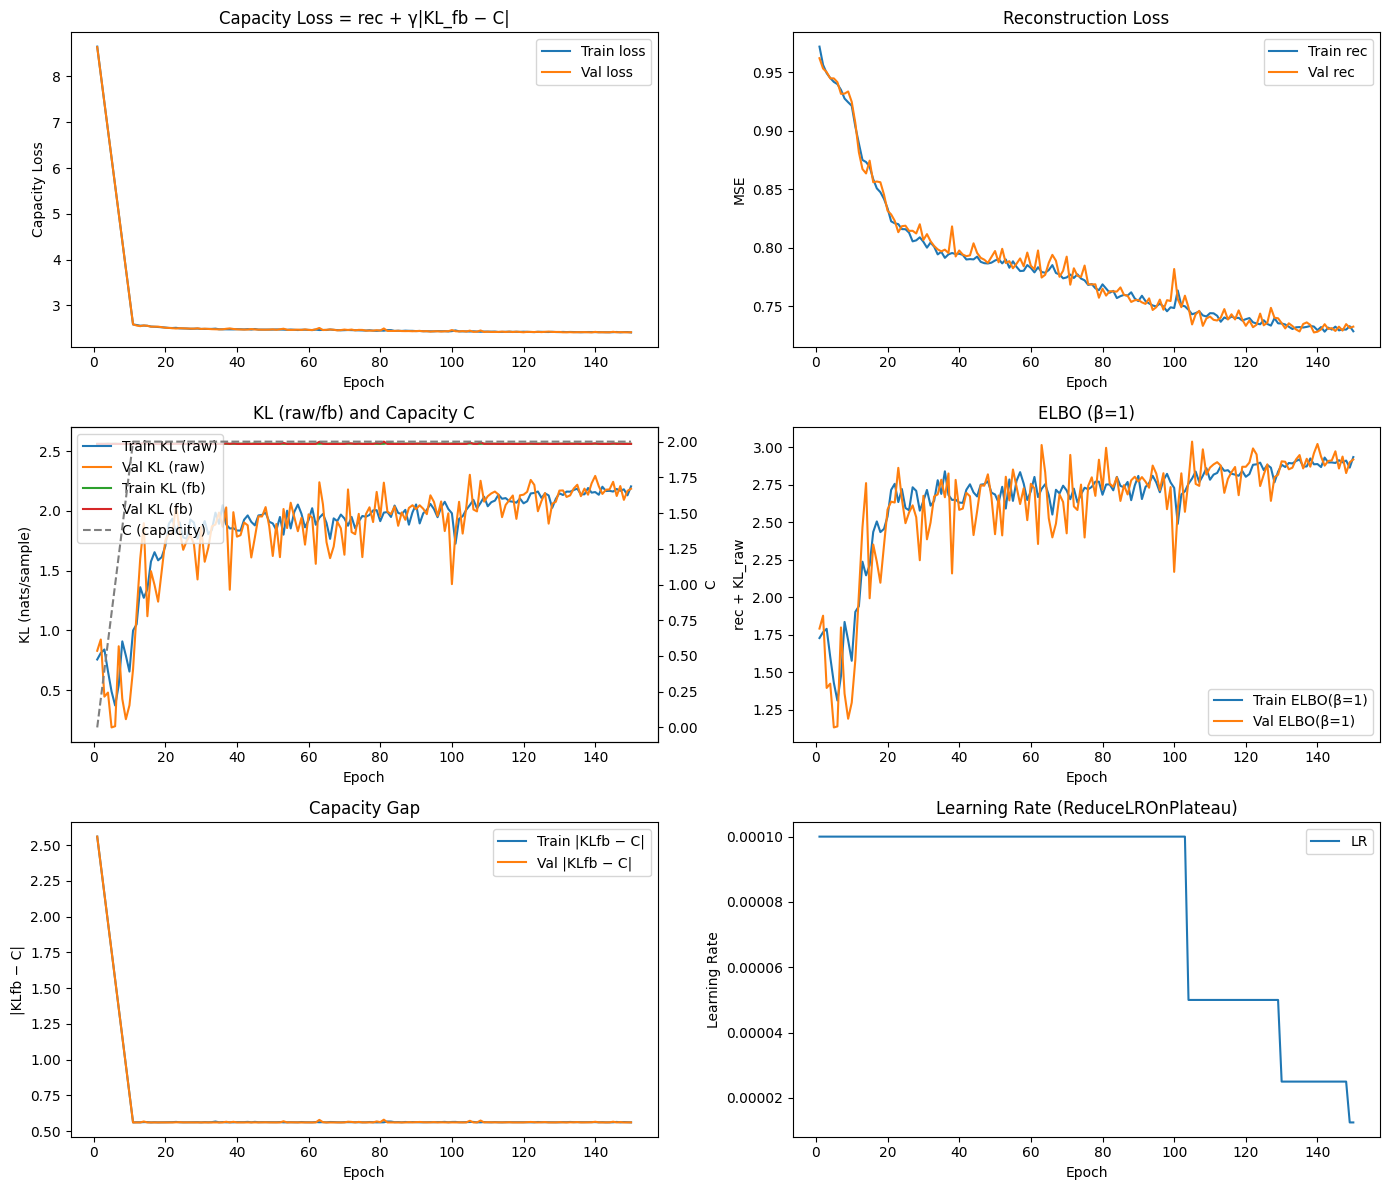

In [19]:
# ========= 可視化 (1枚に統合) =========
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(train_loss_hist) + 1)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

# (1) Capacity-loss
axes[0].plot(epochs, train_loss_hist, label="Train loss")
axes[0].plot(epochs, val_loss_hist, label="Val loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Capacity Loss")
axes[0].set_title("Capacity Loss = rec + γ|KL_fb − C|")
axes[0].legend()

# (2) Reconstruction
axes[1].plot(epochs, train_rec_hist, label="Train rec")
axes[1].plot(epochs, val_rec_hist, label="Val rec")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MSE")
axes[1].set_title("Reconstruction Loss")
axes[1].legend()

# (3) KL(raw) vs KL(fb) と C
ax1 = axes[2]
ax1.plot(epochs, train_kl_raw_hist, label="Train KL (raw)")
ax1.plot(epochs, val_kl_raw_hist, label="Val KL (raw)")
ax1.plot(epochs, train_kl_fb_hist, label="Train KL (fb)")
ax1.plot(epochs, val_kl_fb_hist, label="Val KL (fb)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("KL (nats/sample)")
ax2 = ax1.twinx()
ax2.plot(epochs, C_values, color="tab:gray", linestyle="--", label="C (capacity)")
ax2.set_ylabel("C")
lns = ax1.get_lines() + ax2.get_lines()
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper left")
ax1.set_title("KL (raw/fb) and Capacity C")

# (4) ELBO(β=1)
axes[3].plot(epochs, train_elbo_hist, label="Train ELBO(β=1)")
axes[3].plot(epochs, val_elbo_hist, label="Val ELBO(β=1)")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("rec + KL_raw")
axes[3].set_title("ELBO (β=1)")
axes[3].legend()

# (5) Capacity gap
axes[4].plot(epochs, train_capgap_hist, label="Train |KLfb − C|")
axes[4].plot(epochs, val_capgap_hist, label="Val |KLfb − C|")
axes[4].set_xlabel("Epoch")
axes[4].set_ylabel("|KLfb − C|")
axes[4].set_title("Capacity Gap")
axes[4].legend()

# (6) Learning rate
axes[5].plot(epochs, lr_hist, label="LR")
axes[5].set_xlabel("Epoch")
axes[5].set_ylabel("Learning Rate")
axes[5].set_title("Learning Rate (ReduceLROnPlateau)")
axes[5].legend()

plt.tight_layout()
plt.show()

In [20]:
model.eval()

with torch.no_grad():
    mu, logvar = model.encode(x_gene_tensor, x_drug_tensor)

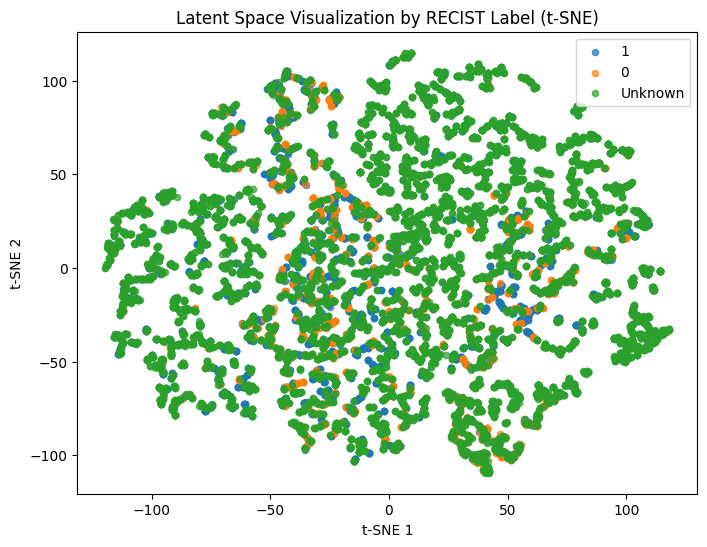

In [21]:
z_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(
    mu.cpu().numpy()
)

plt.figure(figsize=(8, 6))
labels = df["recist_label"].values
unique_labels = list(set(labels))
for lbl in unique_labels:
    idxs = labels == lbl
    plt.scatter(z_2d[idxs, 0], z_2d[idxs, 1], label=lbl, alpha=0.7, s=20)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Latent Space Visualization by RECIST Label (t-SNE)")
plt.legend()
plt.show()

/tmp/ipykernel_21240/1645542975.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20b", 33)


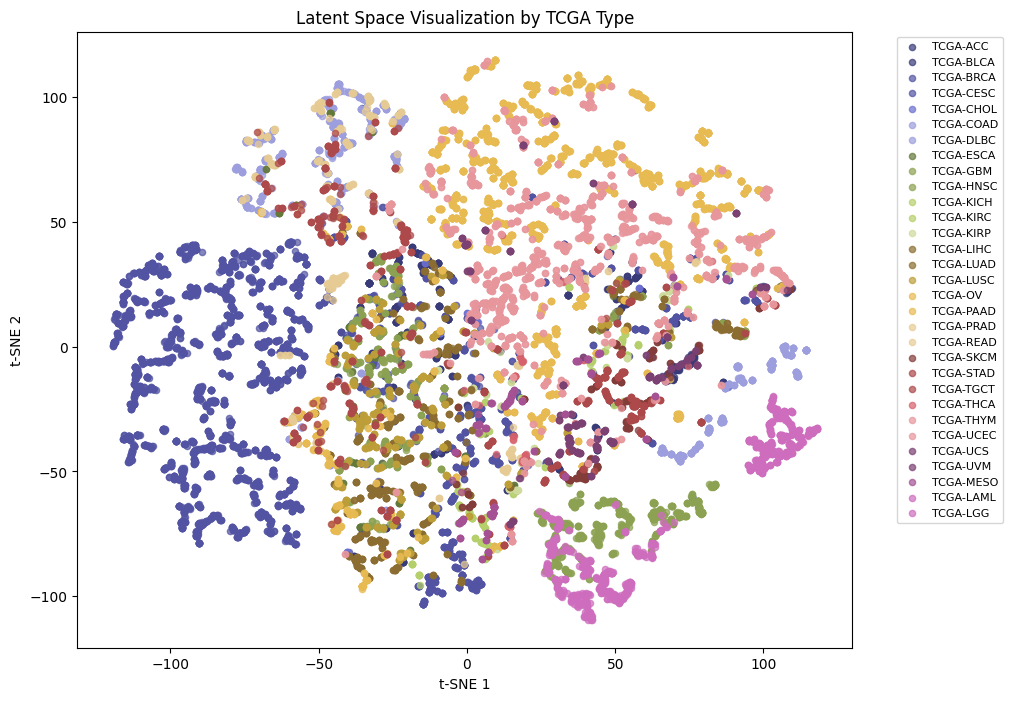

In [22]:
plt.figure(figsize=(10, 8))

tcga_types = df["project.project_id"].unique()
colors = plt.cm.get_cmap("tab20b", 33)

for i, tcga in enumerate(tcga_types):
    idxs = df["project.project_id"] == tcga
    plt.scatter(
        z_2d[idxs, 0], z_2d[idxs, 1], label=tcga, alpha=0.7, s=20, color=colors(i)
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Latent Space Visualization by TCGA Type")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.show()

/tmp/ipykernel_21240/2892930016.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 20)


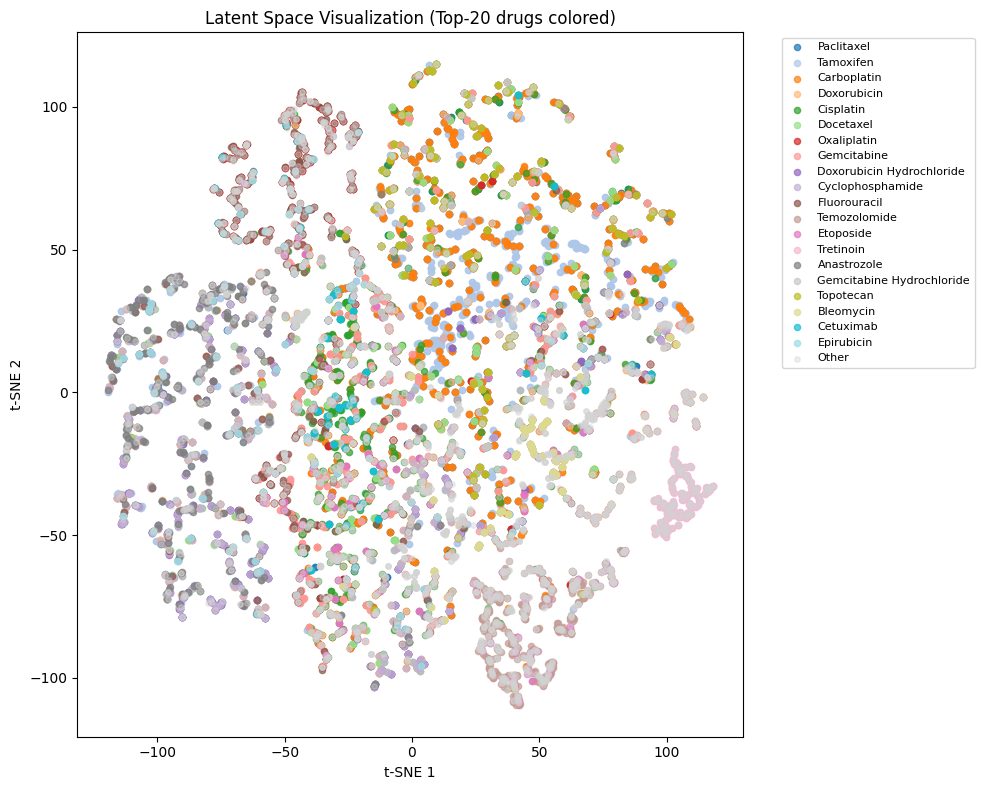

In [23]:
plt.figure(figsize=(10, 8))

counts = df["treatments.therapeutic_agents"].value_counts()
top20 = counts.head(20).index.tolist()
cmap = plt.cm.get_cmap("tab20", 20)

for i, drug in enumerate(top20):
    idxs = (df["treatments.therapeutic_agents"] == drug).values
    plt.scatter(
        z_2d[idxs, 0], z_2d[idxs, 1], label=drug, alpha=0.7, s=20, color=cmap(i)
    )

other_idxs = ~df["treatments.therapeutic_agents"].isin(top20).values
if np.any(other_idxs):
    plt.scatter(
        z_2d[other_idxs, 0],
        z_2d[other_idxs, 1],
        label="Other",
        alpha=0.4,
        s=15,
        color="lightgray",
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Latent Space Visualization (Top-20 drugs colored)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()